In [160]:
from __future__ import print_function, division
import example_helper
import json
import csv
import numpy as np
from deepmoji.sentence_tokenizer import SentenceTokenizer
from deepmoji.model_def import deepmoji_emojis
from deepmoji.global_variables import PRETRAINED_PATH, VOCAB_PATH
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd  
import seaborn as sns 

In [10]:
##Load in the data

df=pd.read_csv('/Users/adrianapaza/Documents/ResearchProjects/Fluency_framing/Data/Change.org_12575680_12507680_english.csv')

/Users/adrianapaza/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (38,128,144,221) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [84]:
6911/2

3455.5

In [11]:
#This function can split the entire text of Huckleberry Finn into sentences in about 0.1 seconds and handles many of the more painful edge cases that make sentence parsing non-trivial e.g. "Mr. John Johnson Jr. was born in the U.S.A but earned his Ph.D. in Israel before joining Nike Inc. as an engineer. He also worked at craigslist.org as a business analyst."

# -*- coding: utf-8 -*-
import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"
def split_into_sentences(text):
    text = str(text)
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    
    sentences = text.split("<stop>")
    #print(sentences)
    #print(len(sentences))
    if len(sentences)>1:
        sentences = sentences[:-1]
    else:
        sentences = sentences[:]
    sentences = [s.strip() for s in sentences]
    return sentences


#also clean html
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

In [12]:
split_into_sentences(df.description.iloc[1])

['<p>For me the transport strike that happened\xc2\xa0 was good in the sense that the old jeepneys were going to be phased out.',
 "It's for our own safety."]

In [13]:
def top_elements(array, k):
    ind = np.argpartition(array, -k)[-k:]
    return ind[np.argsort(array[ind])][::-1]




In [277]:
#Load model in correct working directory
import os
os.chdir('/Users/adrianapaza/Documents/ResearchProjects/Fluency_framing/DeepMoji/examples')
maxlen = 30
batch_size = 32
print('Loading model from {}.'.format(PRETRAINED_PATH))
model = deepmoji_emojis(maxlen, PRETRAINED_PATH)
model.summary()



print('Tokenizing using dictionary from {}'.format(VOCAB_PATH))
with open(VOCAB_PATH, 'r') as f:
    vocabulary = json.load(f)
    

st = SentenceTokenizer(vocabulary, maxlen)


Loading model from /Users/adrianapaza/Documents/ResearchProjects/Fluency_framing/DeepMoji/model/deepmoji_weights.hdf5.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 256)      12800000    input_2[0][0]                    
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 30, 256)      0           embedding[0][0]                  
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       (None, 30, 1024)     3149824     activation_2[0][0]      

In [15]:



#prob = model.predict(tokenized)


## GEt mean emotions
def emoji_scores_unicode_sentences(Sentences):
    #Rewrite sentences into unicode from list of sentences
    #print((cleanhtml(Sentences)))
    Sentences = [unicode(sentence,'utf-8') for sentence in (Sentences)]
    tokenized, _, _ = st.tokenize_sentences(Sentences,'utf-8')
    #print(Sentences)
    
    prob = model.predict(tokenized)
    #print(Sentences)
    #initialize lists to store values, loop over all sentences and then average.
    t_prob=[]
    all_scores=[]
    for i, t in enumerate(Sentences):
        t_tokens = tokenized[i]
        t_score = [t]
        t_prob_current =  prob[i]
        all_scores.append(t_prob_current)
    return(np.array(all_scores).mean(axis=0)) #return the mean across sentences
    
    

In [16]:
#emoji_scores_unicode_sentences(df.cleaned_description.iloc[0])

AttributeError: 'DataFrame' object has no attribute 'cleaned_description'

In [17]:
#clean sentences html
df['cleaned_description'] = df.description.apply(lambda x:split_into_sentences(cleanhtml(x)))

In [18]:
#ensure we only use data that is non-empty
def check_contains_words(X):
    return(('' in X)==False)
    
df_complete_cases= df[df.cleaned_description.apply(check_contains_words)]

In [19]:
df_complete_cases['Emoji_Probs']=df_complete_cases.cleaned_description.apply(lambda x: emoji_scores_unicode_sentences(x) )

/Users/adrianapaza/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [151]:
##do it for the asks too
df_complete_cases['cleaned_asks'] = df_complete_cases.ask.apply(lambda x:split_into_sentences(cleanhtml(x)))
df_complete_cases['Asks_Emoji_Probs']=df_complete_cases.cleaned_asks.apply(lambda x: emoji_scores_unicode_sentences(x) )

/Users/adrianapaza/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/adrianapaza/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [153]:
Complete_Emojis_old = df_complete_cases['Emoji_Probs'][:]
Ask_Complete_Emojis_old = df_complete_cases['Emoji_Probs'][:]


In [86]:
#list of variable names
emoji_names = []
for i in range(0,64):
    emoji_names.append('emoji_'+str(i))
#emoji_names

In [87]:
#create dataframe of just the emoji values
df_emojis_raw= pd.DataFrame(Complete_Emojis_old)

df_emojis_raw[emoji_names] = pd.DataFrame(df_emojis_raw.Emoji_Probs.tolist(), index= df_emojis_raw.index)
df_emojis_raw.drop('Emoji_Probs', axis=1, inplace=True)

In [154]:
#create dataframe of just the emoji values for the asks
df_emojis_raw_ask= pd.DataFrame(Ask_Complete_Emojis_old)

df_emojis_raw_ask[emoji_names] = pd.DataFrame(df_emojis_raw_ask.Emoji_Probs.tolist(), index= df_emojis_raw_ask.index)
df_emojis_raw_ask.drop('Emoji_Probs', axis=1, inplace=True)

## PCA Analysis

In [198]:
from sklearn.decomposition import PCA

Num_components = 10
pca = PCA(n_components=Num_components)
principalComponents = pca.fit_transform(df_emojis_raw)

#list of PCA names
PCA_names = []
for i in range(0,Num_components):
    PCA_names.append('PCA'+str(i+1))

principalDf = pd.DataFrame(data = principalComponents
             , columns = PCA_names)
#finalDf = pd.concat([principalDf, df_new[['target']]], axis = 1)


In [199]:
sum(pca.explained_variance_ratio_[0:4])

0.4553210442595665

In [200]:
principalComponents[0]

array([-0.0609375 , -0.00215499, -0.03848241, -0.03715379,  0.03109435,
        0.06446187,  0.02643487,  0.05727491, -0.02087676,  0.01251879])

In [218]:
print(pca.components_[0].argsort()[-2:][::-1],(-pca.components_[0]).argsort()[-2:][::-1])
print(print(pca.components_[0][pca.components_[0].argsort()[-3:][::-1]]))

print(pca.components_[1].argsort()[-2:][::-1],(-pca.components_[1]).argsort()[-2:][::-1])
print(pca.components_[1][pca.components_[1].argsort()[-3:][::-1]])

print(pca.components_[2].argsort()[-2:][::-1],(-pca.components_[2]).argsort()[-2:][::-1])
print(pca.components_[2][pca.components_[2].argsort()[-3:][::-1]])

print(pca.components_[3].argsort()[-2:][::-1],(-pca.components_[3]).argsort()[-2:][::-1])
print(print(pca.components_[3][pca.components_[3].argsort()[-3:][::-1]]))

print(pca.components_[4].argsort()[-2:][::-1],(-pca.components_[4]).argsort()[-2:][::-1])
print(print(pca.components_[4][pca.components_[4].argsort()[-3:][::-1]]))

[32 55] [21 57]
[0.49633247 0.40689423 0.20468407]
None
[46 34] [33 32]
[0.52546533 0.32502065 0.23812611]
[21 32] [39 56]
[0.58084545 0.34764724 0.23049479]
[21 39] [11 48]
[0.49180027 0.44420231 0.13275065]
None
[39 21] [22 33]
[0.50413351 0.35678408 0.31245125]
None


In [202]:
#get PCA for each row
Fitted_PCA_data = pca.transform(df_emojis_raw)
Fitted_PCA_data = pd.DataFrame(Fitted_PCA_data,columns =PCA_names )

In [203]:
df_complete_cases

,id,ask,calculated_goal,copylink_share_copy_bandit_definition.experimentName,copylink_share_copy_bandit_definition.selectedVariant.data.description,copylink_share_copy_bandit_definition.selectedVariant.data.headline,copylink_share_copy_bandit_definition.selectedVariant.data.message,copylink_share_copy_bandit_definition.selectedVariant.pulls,copylink_share_copy_bandit_definition.selectedVariant.rewards,copylink_share_copy_bandit_definition.selectedVariant.variantName,...,whatsapp_share_copy_bandit_definition.selectedVariant.data.message,whatsapp_share_copy_bandit_definition.selectedVariant.pulls,whatsapp_share_copy_bandit_definition.selectedVariant.rewards,whatsapp_share_copy_bandit_definition.selectedVariant.variantName,whatsapp_share_copy_bandit_definition.variants,log_signatures+1,cleaned_description,Emoji_Probs,cleaned_asks,Asks_Emoji_Probs
0,12575680,"Don't send Qi Yuan, Qi Gui & Yuan Man into the...",100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.693147,[They can't survive in the wild cause so close w],"[0.0068576783, 0.0057126856, 0.014024086, 0.01...","[Don't send Qi Yuan, Qi Gui & Yuan Man into th...","[0.01497195, 0.012656513, 0.0069218464, 0.0093..."
1,12575683,TRANSPORT STRIKE,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.693147,[For me the transport strike that happened wa...,"[0.009678226, 0.019158255, 0.0044362443, 0.004...",[TRANSPORT STRIKE],"[0.004488589, 0.024001412, 0.007800467, 0.0144..."
2,12575689,Transport Strike,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.693147,[Due to the Transport Strike that happened yes...,"[0.0175562, 0.03595856, 0.010322612, 0.0107982...",[Transport Strike],"[0.004488589, 0.024001412, 0.007800467, 0.0144..."
3,12575692,Difficulties For Diabetic Patients In Dental I...,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.693147,[As the life expectancy of individuals continu...,"[0.008743567, 0.015550871, 0.00789038, 0.00769...",[Difficulties For Diabetic Patients In Dental ...,"[0.0065161944, 0.023820732, 0.014789219, 0.012..."
4,12575695,Don't change the jeepney,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.693147,[Government don't need to take away the old je...,"[0.006337524, 0.016874693, 0.0033467053, 0.004...",[Don't change the jeepney],"[0.011645439, 0.014909507, 0.0057351943, 0.008..."
5,12575698,Stop the Federal Government from removing Natu...,10000,cl_sharecopy_12575698_en-AU,%{petition_name},Join %{sharer_name} and make a difference in t...,Can you help out by signing this petition?,0.0,0.0,v11,...,NaN,NaN,NaN,NaN,NaN,9.131297,[The Australian Federal Health Minister Greg H...,"[0.005864679, 0.010894762, 0.003901805, 0.0051...",[Stop the Federal Government from removing Nat...,"[0.0035282932, 0.03288261, 0.007610843, 0.0067..."
6,12575701,2 Days strike,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.693147,[many transport groups make a strike for 2 day...,"[0.0040707835, 0.031563625, 0.0070974417, 0.00...",[2 Days strike],"[0.0026280202, 0.0050751413, 0.0066300984, 0.0..."
7,12575704,jeepney strike,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.693147,[last timethere was a philippine strike becaus...,"[0.012580211, 0.016195927, 0.0047052098, 0.006...",[jeepney strike],"[0.010091082, 0.00806309, 0.0037493063, 0.0069..."
8,12575707,End genetic discrimination by insurance providers,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.693147,[There is a concerning lack of regulation over...,"[0.007865129, 0.019902749, 0.0060990816, 0.005...",[End genetic discrimination by insurance provi...,"[0.01711501, 0.023561219, 0.006742939, 0.01245..."
9,12575710,STRIKE,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.693147,[TRANSPORTATION STRIKE is a big problem for je...,"[0.01063702, 0.028742235, 0.0050624125, 0.0051...",[STRIKE],"[0.0053979736, 0.008969158, 0.0017073451, 0.00..."


In [204]:
#merge
#pd.merge(df_complete_cases,Fitted_PCA_data,left_on='id')
Fitted_PCA_data['id']= df_complete_cases.id

df_complete = pd.merge(df_complete_cases,Fitted_PCA_data,how='inner')

In [205]:
df_complete = df_complete.drop_duplicates(subset=['id'], keep='first')

In [206]:
#get word counts
df_complete['num_words'] = df_complete.cleaned_description.apply(lambda X: sum([len(x.split(" ")) for x in X]) )

In [207]:
df_complete

,id,ask,calculated_goal,copylink_share_copy_bandit_definition.experimentName,copylink_share_copy_bandit_definition.selectedVariant.data.description,copylink_share_copy_bandit_definition.selectedVariant.data.headline,copylink_share_copy_bandit_definition.selectedVariant.data.message,copylink_share_copy_bandit_definition.selectedVariant.pulls,copylink_share_copy_bandit_definition.selectedVariant.rewards,copylink_share_copy_bandit_definition.selectedVariant.variantName,...,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,num_words
0,12575680,"Don't send Qi Yuan, Qi Gui & Yuan Man into the...",100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.002155,-0.038483,-0.037161,0.031086,0.064491,0.026391,0.057250,-0.020886,0.012511,10
1,12575683,TRANSPORT STRIKE,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.027834,0.019006,0.005381,0.019072,0.039176,-0.003225,0.020320,0.022238,0.013818,27
2,12575689,Transport Strike,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.026689,0.027886,-0.000513,-0.015709,0.008687,-0.018251,-0.002896,0.016617,-0.012777,67
3,12575692,Difficulties For Diabetic Patients In Dental I...,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.001621,-0.024366,0.036533,0.003536,-0.033195,-0.025054,0.017509,0.005984,0.001758,471
4,12575695,Don't change the jeepney,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.030115,0.030718,-0.013154,0.012246,-0.014473,0.027248,0.002624,-0.013939,0.000112,34
5,12575698,Stop the Federal Government from removing Natu...,10000,cl_sharecopy_12575698_en-AU,%{petition_name},Join %{sharer_name} and make a difference in t...,Can you help out by signing this petition?,0.0,0.0,v11,...,-0.022395,0.036898,0.017910,0.004715,-0.014192,-0.010108,0.000775,-0.003099,0.005538,336
6,12575701,2 Days strike,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.030707,0.034323,-0.041372,0.025137,-0.014144,0.010496,-0.015896,0.016055,0.007002,19
7,12575704,jeepney strike,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.053037,0.060657,-0.027762,0.019857,-0.026028,-0.005714,0.011484,-0.014383,0.007761,23
8,12575707,End genetic discrimination by insurance providers,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.013376,0.010445,0.015424,-0.014937,-0.007481,-0.026758,0.002820,-0.006261,0.004701,873
9,12575710,STRIKE,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.077228,0.052847,-0.014620,0.009101,-0.014329,-0.018824,-0.010738,-0.005292,0.006036,70


In [208]:
#save data
import os
os.chdir('/Users/adrianapaza/Documents/ResearchProjects/Fluency_framing/Data')
df_complete.to_csv('Post_PCA_data.csv')

In [209]:
os.getcwd()


'/Users/adrianapaza/Documents/ResearchProjects/Fluency_framing/Data'

## Plotting

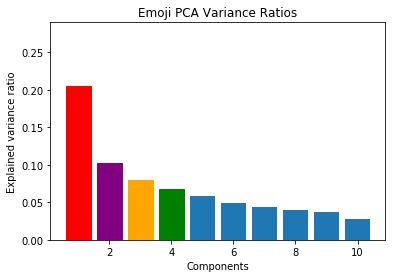

In [275]:
#plot hist of PCA emojis
pcamodel=pca
bar_list = plt.bar(range(1,len(pcamodel.explained_variance_ratio_ )+1),pcamodel.explained_variance_ratio_ )
plt.ylabel('Explained variance ratio')
plt.xlabel('Components')
bar_list[0].set_color('r')
bar_list[1].set_color('purple')
bar_list[2].set_color('orange')
bar_list[3].set_color('g')
plt.ylim(0, .29)

plt.title('Emoji PCA Variance Ratios')

plt.savefig('PCA_Emotions.png')


In [260]:
##Plot raw emojis
mean_emojis = np.array(df_emojis_raw.mean(axis=0))
top_emojis = mean_emojis.argsort()[-10:][::-1]
top_emojis

array([32, 55, 33, 25, 21, 19, 22, 46, 58, 37])

In [256]:
mean_emojis = df_emojis_raw.mean(axis=0)


array([0.01161752, 0.018533  , 0.00887187, 0.01078218, 0.00684264,
       0.01613635, 0.01642655, 0.01222524, 0.01084775, 0.01073675,
       0.01220486, 0.01421067, 0.01709328, 0.01589338, 0.00876624,
       0.01301546, 0.01141133, 0.01538416, 0.00601301, 0.0243653 ,
       0.01506367, 0.02542161, 0.02432659, 0.00331374, 0.01258629,
       0.02612395, 0.01069874, 0.01908452, 0.01049279, 0.01100293,
       0.01829752, 0.01391268, 0.03688958, 0.0290558 , 0.02065895,
       0.01679401, 0.00748515, 0.02173384, 0.01644929, 0.01612242,
       0.0190122 , 0.01452912, 0.01955381, 0.01829212, 0.01840461,
       0.01829785, 0.02354344, 0.01179927, 0.01095977, 0.00963283,
       0.01200983, 0.01335624, 0.01690299, 0.01453954, 0.01005797,
       0.03313365, 0.0170949 , 0.01894854, 0.02262894, 0.00872372,
       0.00583315, 0.01325228, 0.01921098, 0.01339065])

In [261]:
mean_emojis[top_emojis]


array([0.03688958, 0.03313365, 0.0290558 , 0.02612395, 0.02542161,
       0.0243653 , 0.02432659, 0.02354344, 0.02262894, 0.02173384])

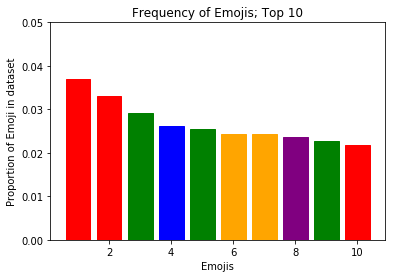

In [276]:
bar_list = plt.bar(range(1,len(mean_emojis[top_emojis] )+1),mean_emojis[top_emojis] )
plt.ylabel('Proportion of Emoji in dataset')
plt.xlabel('Emojis')
bar_list[0].set_color('r')
bar_list[1].set_color('r')
bar_list[2].set_color('g')
bar_list[3].set_color('b')
bar_list[4].set_color('g')
bar_list[5].set_color('orange')
bar_list[6].set_color('orange')
bar_list[7].set_color('purple')
bar_list[8].set_color('g')
bar_list[9].set_color('r')

plt.ylim(0, .05)

plt.title('Frequency of Emojis; Top 10')

plt.savefig('Emotion_distributions.png')